Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2052 - loss: 1.3951
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2040 - loss: 1.3981
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2257 - loss: 1.3855
Epoch 4/30
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0938 - loss: 1.4032

c:\Users\DeepanshuMidha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2075 - loss: 1.3883 
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2958 - loss: 1.3701 
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2623 - loss: 1.3777
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3212 - loss: 1.3742 
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3306 - loss: 1.3661
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2842 - loss: 1.3672 
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3613 - loss: 1.3589 
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3478 - loss: 1.3579 
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4813 - loss: 1.3409 
Epoch 13/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4982 - loss: 1.3281 
Epoch 14/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6210 - loss: 1.3040 
Epoch 15/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5446 - loss: 1.2937 
Epoch 16/

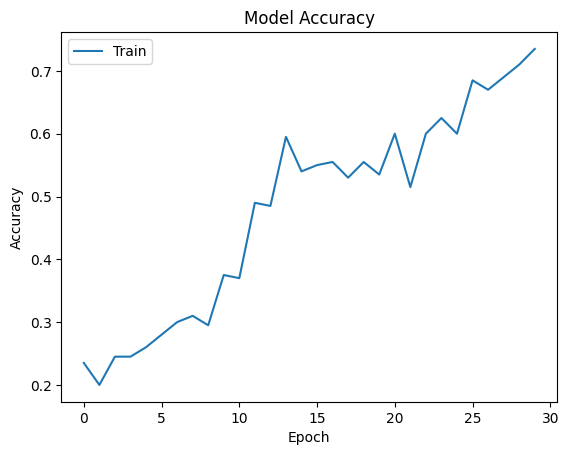

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Model
from keras.layers import Dense, Conv1D, MaxPooling1D, LeakyReLU, Flatten, Input, BatchNormalization, ReLU, Dropout, Add


root_dir = r'C:\Users\DeepanshuMidha\Desktop\50-20-10-LSTM'

# Function to load and preprocess data
def load_data(root_dir):
    devices = ['BULB', 'FAN', 'KETTLE', 'OVEN']
    data = []
    labels = []

    # Label Encoder to convert appliance names to integers
    label_encoder = LabelEncoder()
    label_encoder.fit(devices)  # Fit on the device names
    
    for device in devices:
        device_dir = os.path.join(root_dir, device)
        files = [f for f in os.listdir(device_dir) if f.endswith('.csv')]
        
        for file in files:
            file_path = os.path.join(device_dir, file)
            df = pd.read_csv(file_path)
            
            # Ensure the data contains the necessary columns
            df = df[['Voltage', 'Current', 'Real Power', 'Reactive Power', 'Apparent Power', 
                     'Power Factor', 'Frequency', 'THD', 'Appliance', 'SequenceID']]
            
            # Normalize the feature columns using StandardScaler
            # features = df[['Voltage', 'Current', 'Real Power', 'Reactive Power', 'Apparent Power','Power Factor', 'Frequency', 'THD']].values
            features = df[['Current', 'Real Power', 'Reactive Power', 'Apparent Power', 
                'Power Factor', 'Frequency', 'THD']].values  # Excluding 'Voltage'


            # scaler = StandardScaler()
            scaler = MinMaxScaler(feature_range=(0,1))
            features = scaler.fit_transform(features)
            
            # Sequence ID should be dropped since it's not a feature but an identifier
            sequence_ids = df['SequenceID'].values
            
            # Add to our data list
            for i in range(0, len(df), 20):  # Assuming 20 samples per file
                data.append(features[i:i + 20])  # 20 samples as sequences
                
                # Convert appliance names to integer labels using label encoder
                label = label_encoder.transform([device])[0]  # Convert device name to integer
                labels.append(label)  # Assign integer label corresponding to the device

    # Convert data and labels to numpy arrays
    data = np.array(data)
    labels = np.array(labels)
    
    # Return the data and labels
    return data, labels, label_encoder

# Load the data
data, labels, label_encoder = load_data(root_dir)

# Split into training and test data
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X, y = data, labels

# LSTM Model 3
model = Sequential()
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))  # Increase dropout
model.add(LSTM(32, return_sequences=False))  # Fewer LSTM units
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Output layer
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, epochs=30, batch_size=32)

loss, accuracy = model.evaluate(X, y)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Save the model after training
# model.save('appliance_model.h5')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


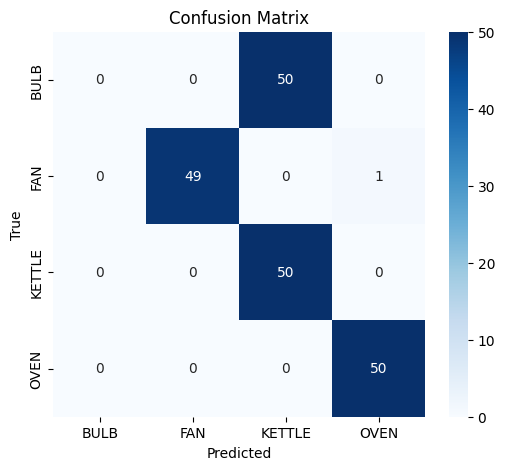

In [14]:
from keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('appliance_model.h5')

def load_test_data(test_dir, label_encoder):
    devices = ['BULB', 'FAN', 'KETTLE', 'OVEN']
    # devices = ['FAN']
    test_data = []
    test_labels = []

    # Label Encoder to convert appliance names to integers
    label_encoder = label_encoder

    for device in devices:
        device_dir = os.path.join(test_dir, device)
        files = [f for f in os.listdir(device_dir) if f.endswith('.csv')]

        for file in files:
            file_path = os.path.join(device_dir, file)
            df = pd.read_csv(file_path)

            # Ensure the data contains the necessary columns
            df = df[['Voltage', 'Current', 'Real Power', 'Reactive Power', 'Apparent Power', 
                     'Power Factor', 'Frequency', 'THD', 'Appliance', 'SequenceID']]
            
            # Extract the features (excluding 'Voltage')
            features = df[['Current', 'Real Power', 'Reactive Power', 'Apparent Power', 
                           'Power Factor', 'Frequency', 'THD']].values

            # Normalize the features using the same scaler used during training
            # scaler = StandardScaler()
            scaler = MinMaxScaler(feature_range=(0,1))
            features = scaler.fit_transform(features)

            # Create sequences from the features (20 samples per sequence)
            for i in range(0, len(df), 20):
                test_data.append(features[i:i + 20])  # 20 samples as sequences

                # Convert appliance names to integer labels using label encoder
                label = label_encoder.transform([device])[0]  # Convert device name to integer
                test_labels.append(label)  # Assign integer label corresponding to the device

    # Convert test data and labels to numpy arrays
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)

    return test_data, test_labels

# Define your test folder
test_dir = r'C:\Users\DeepanshuMidha\Desktop\50-20-10-LSTM'

# Load the test data
X_test, y_test = load_test_data(test_dir, label_encoder)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert predictions from probabilities to class labels (by taking the argmax)
y_pred_labels = np.argmax(y_pred, axis=1)

# Evaluate model performance (you can compare predictions with ground truth)
# print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [3]:
# # LSTM Model 1
# model = Sequential()
# model.add(LSTM(64, return_sequences=False))
# model.add(Dropout(0.2))  # Dropout layer for regularization
# model.add(Dense(32, activation='relu'))
# model.add(Dense(4, activation='softmax'))  # Output layer for multi-class classification (4 classes)
# model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))
# # Evaluate the model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f"Test Accuracy: {accuracy:.4f}")
# predictions = model.predict(X_test)
# predicted_labels = np.argmax(predictions, axis=1)
# print(f"Predicted values (device indices): {predicted_labels[:10]}")
# print(f"Actual values (device indices): {y_test[:10]}")
# predicted_device_names = label_encoder.inverse_transform(predicted_labels)
# actual_device_names = label_encoder.inverse_transform(y_test)
# print(f"Predicted device names: {predicted_device_names[:10]}")
# print(f"Actual device names: {actual_device_names[:10]}")

# # LSTM Model 2
# model = Sequential()
# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.2))  # Dropout for regularization
# model.add(LSTM(64, return_sequences=False))  # Second LSTM layer
# model.add(Dropout(0.2))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(4, activation='softmax'))  # Multi-class classification
# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])
# # Evaluate the model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f"Test Accuracy: {accuracy:.4f}")
# predictions = model.predict(X_test)
# predicted_labels = np.argmax(predictions, axis=1)
# print(f"Predicted values (device indices): {predicted_labels[:10]}")
# print(f"Actual values (device indices): {y_test[:10]}")
# predicted_device_names = label_encoder.inverse_transform(predicted_labels)
# actual_device_names = label_encoder.inverse_transform(y_test)
# print(f"Predicted device names: {predicted_device_names[:10]}")
# print(f"Actual device names: {actual_device_names[:10]}")